In [2]:
import torch
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from nltk.corpus import wordnet
import nltk

# Ensure WordNet is downloaded
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Complexity Detection with BERT

### DataLoader

In [ ]:
class ComplexityDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sentence = self.df.iloc[idx]['sentence']
        token = self.df.iloc[idx]['token']
        difficulty = self.df.iloc[idx]['difficulty']

        inputs = self.tokenizer(sentence, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'labels': torch.tensor(difficulty, dtype=torch.float)
        }


In [ ]:
# Load dataset
df = pd.read_csv("/content/train_dataset.csv") 

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Train-test split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Create datasets
train_dataset = ComplexityDataset(train_df, tokenizer)
val_dataset = ComplexityDataset(val_df, tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Train Model

In [ ]:
# Load BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Train the model

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Train model
trainer.train()

# Save model
model.save_pretrained("./complexity_model")
tokenizer.save_pretrained("./complexity_model")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: thalask4 (thalask4-sap) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.021400,0.018278
2,0.019400,0.015962


('./complexity_model/tokenizer_config.json',
 './complexity_model/special_tokens_map.json',
 './complexity_model/vocab.txt',
 './complexity_model/added_tokens.json')

### Function to get synonym and an exmaple usage for most complex word

In [ ]:
def get_most_complex_word_gloss(sentence, threshold=0.5):
    words = sentence.split()
    max_score = threshold
    most_complex_word = None

    for word in words:
        inputs = tokenizer(word, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to CUDA

        with torch.no_grad():
            output = model(**inputs)
        difficulty_score = output.logits.item()

        if difficulty_score > max_score:
            max_score = difficulty_score
            most_complex_word = word

    if most_complex_word:
        synsets = wordnet.synsets(most_complex_word)
        if synsets:
            example_sentences = synsets[0].examples()
            # synonyms = [lemma.name() for lemma in synsets[0].lemmas() if lemma.name().lower() != most_complex_word.lower()]
            # print(synonyms)
            synonyms = []
            for syn in wordnet.synsets(most_complex_word):
                for lemma in syn.lemmas():
                    if lemma.name().lower() != most_complex_word.lower():
                        synonyms.append(lemma.name())
            valid_synonyms = []
            for synonym in synonyms:
                new_sentence.replace(most_complex_word, synonym)
                synonym_words = new_sentence.split()

                inputs = tokenizer(synonym, return_tensors="pt", padding=True, truncation=True, max_length=128)
                inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to CUDA

                with torch.no_grad():
                    output = model(**inputs)
                difficulty_score = output.logits.item()
                #print(difficulty_score)

                if difficulty_score <= max_score:
                    valid_synonyms.append([synonym,difficulty_score])


            if valid_synonyms:
                # Find the most frequently used synonym
                most_related_synonym = min(valid_synonyms, key=lambda x: x[1])[0]
                sorted_synonyms = sorted(valid_synonyms, key=lambda x: x[1])

                for syn in sorted_synonyms:

                    # Get an example sentence for the synonym
                    synonym_synsets = wordnet.synsets(syn[0])
                    synonym_example = synonym_synsets[0].examples() if synonym_synsets else []

                    if synonym_example:
                        return {
                          "complex_word": most_complex_word,
                          "complex_example": example_sentences[0] if example_sentences else "No example available",
                          "synonym": most_related_synonym,
                          "synonym_example": synonym_example[0] if synonym_example else "No example available"
                    }
            antonyms = []
            for syn in wordnet.synsets(most_complex_word):
                for lemma in syn.lemmas():
                    if lemma.antonyms():
                        for antonym in lemma.antonyms():
                            antonyms.append(antonym)
            valid_antonyms = []
            for antonym in antonyms:

                inputs = tokenizer(antonym, return_tensors="pt", padding=True, truncation=True, max_length=128)
                inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to CUDA

                with torch.no_grad():
                    output = model(**inputs)
                difficulty_score = output.logits.item()
                #print(difficulty_score)

                valid_antonyms.append([antonym,difficulty_score])


            if valid_antonyms:
                # Find the most frequently used synonym
                most_related_antonym = min(valid_antonyms, key=lambda x: x[1])[0]
                sorted_antonyms = sorted(valid_antonyms, key=lambda x: x[1])

                for ant in sorted_antonyms:

                    # Get an example sentence for the synonym
                    antonym_synsets = wordnet.synsets(ant[0])
                    antonym_example = antonym_synsets[0].examples() if antonym_synsets else []

                    if synonym_example:
                        return {
                          "complex_word": most_complex_word,
                          "complex_example": example_sentences[0] if example_sentences else "No example available",
                          "antonym": most_related_antonym,
                          "antonym_example": antonym_example[0] if antonym_example else "No example available"
                    }


    return None

### Function to get synonyms for all complex words

In [ ]:
def get_synonym_image(sentence, threshold=0.5):
    words = sentence.split()
    max_score = threshold
    complex_words = []
    result = []
    for word in words:
        inputs = tokenizer(word, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to CUDA

        with torch.no_grad():
            output = model(**inputs)
        difficulty_score = output.logits.item()
        if difficulty_score > threshold:
            complex_words.append([word,difficulty_score])
    if complex_words:
      for complex_word in complex_words:
        synsets = wordnet.synsets(complex_word[0])
        if synsets:
            synonyms = [lemma.name() for lemma in synsets[0].lemmas() if lemma.name().lower() != complex_word[0].lower()]

            valid_synonyms = []
            for synonym in synonyms:

                inputs = tokenizer(synonym, return_tensors="pt", padding=True, truncation=True, max_length=128)
                inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to CUDA

                with torch.no_grad():
                    output = model(**inputs)
                difficulty_score = output.logits.item()

                if difficulty_score <= complex_word[1]:
                    valid_synonyms.append([synonym,difficulty_score])


            if valid_synonyms:
                # Find the most frequently used synonym
                sorted_synonyms = sorted(valid_synonyms, key=lambda x: x[1])
                best_synonym = sorted_synonyms[0][0]
                result.append([complex_word[0],best_synonym])

    return result

### Example usages

In [ ]:
sentence = "The enigmatic phenomenon perplexed the researchers."
print(get_most_complex_word_gloss(sentence, threshold=0.3))

{'complex_word': 'enigmatic', 'complex_example': "I didn't grasp the meaning of that enigmatic comment until much later", 'synonym': 'puzzling', 'synonym_example': 'This beats me!'}


In [ ]:
sentence = "The enigmatic phenomenon perplexed the researchers."
print(get_synonym_image(sentence, threshold=0.25))

[['enigmatic', 'puzzling'], ['perplexed', 'stick']]


In [3]:
words = get_synonym_image(sentence, threshold = 0.25)
new_sentence = sentence.replace(words[0][0], words[0][1])
new_sentence

'The puzzling phenomenon perplexed the researchers.'

## Stable Diffusion

In [20]:
import torch
from PIL import Image

In [1]:
!pip install diffusers
!pip install transformers scipy ftfy accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [4]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [5]:
from diffusers import LMSDiscreteScheduler

scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

In [6]:
vae = vae.to(device)
text_encoder = text_encoder.to(device)
unet = unet.to(device)

In [22]:
prompt = ['Dispersal of crowds of people']

height = 512
width = 512

num_inference_steps = 100            # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise

batch_size = 1

### Generate text embeddings

In [23]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

In [24]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

In [25]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

### Generate initial noise

In [26]:
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(device)

<ipython-input-26-79f43e2fabc0>:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


In [27]:
latents.shape

torch.Size([1, 4, 64, 64])

### Scheduler

In [28]:
scheduler.set_timesteps(num_inference_steps)

In [29]:
latents = latents * scheduler.init_noise_sigma

### Denoising loop

In [30]:
from tqdm.auto import tqdm
from torch import autocast

for t in tqdm(scheduler.timesteps):
  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
  latent_model_input = torch.cat([latents] * 2)

  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/100 [00:00<?, ?it/s]

In [31]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents).sample

### Display image

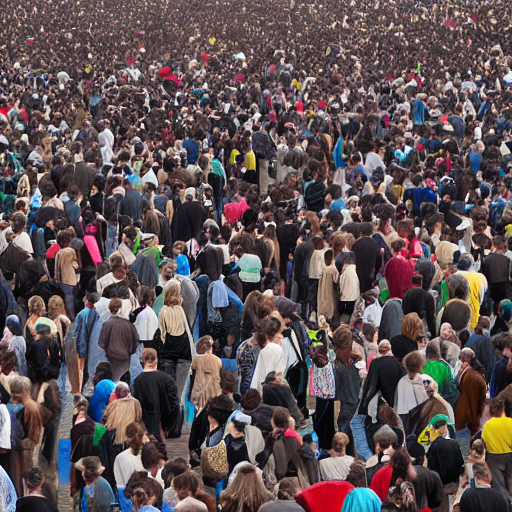

In [32]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]